In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [56]:
# Import functions directly from github
# Important: note that we use raw.githubusercontent.com, not github.com

import requests
url = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/plot_utility.py'
r = requests.get(url)

# Store the file to the colab working directory
with open('plot_utility.py', 'w') as f:
    f.write(r.text)
f.close()

# import the function we want from that file
from plot_utility import plot_tme

# Constants

In [57]:
# System Parameters
m = 0.5 # mass
l = 0.2 # distance from rotor to COM
I = 2/5*m*l**2 # Moment of inertia (Iyy) -- assuming drone is a sphere (it is not)
g = 9.81 # gravity constant

# Control Parameters
tau_k_theta = 10 # torque control to stabilize theta
tau_k_thetadot = 20 # torque control to provide thetadot damping
tau_k_x = 0.01 # torque control to control x position
tau_k_xdot = 0.2 # torque control to provide xdot damping
F_k_z = 1000 # Force control to control z position
F_k_zdot = 10000 # Force control to control z position

F0 = m*g

# Noise for measurements: (standard deviations)
v = [0.01, 0.001, 0.2, 0.2]

# Desired trajectory

In [58]:
def desired_trajectory(t):
    theta_des = 0*np.ones_like(t)
    z_des = 1*np.ones_like(t)
    x_des = np.sin(0.01*t)
    return theta_des, x_des, z_des

# Nonlinear continuous time dynamics with control

In [59]:
def control(X, t):
    theta, thetadot, x, xdot, z, zdot = np.ravel(X)
    
    # desired trajectory
    theta_des, x_des, z_des = desired_trajectory(t)
    
    # error
    x_err = x_des - x
    z_err = z_des - z
    
    # control
    tau = -(tau_k_x*x_err - tau_k_xdot*xdot)  + (tau_k_theta*(-theta) - tau_k_thetadot*thetadot)
    F = (F_k_z*z_err - F_k_zdot*zdot)
    
    return F, tau

In [60]:
def f(X, t):
    theta, thetadot, x, xdot, z, zdot = X
    
    # control
    F, tau = control(X, t)
    
    # dynamics
    d_theta = thetadot
    d_thetadot = tau/I
    d_x = xdot
    d_xdot = -F*np.sin(theta)/m
    d_z = zdot
    d_zdot = (F*np.cos(theta)-m*g)/m
    
    d_x = [d_theta, d_thetadot, d_x, d_xdot, d_z, d_zdot]
    
    return d_x

# Run simulation

In [61]:
t = np.arange(0, 1000, 0.1)

x0 = [(np.random.random()-0.5)*1e-3 for i in range(6)]

result = odeint(f, x0, t)
X = result.T

# Plot results

In [62]:
theta = X[0, :]
x = X[2, :]
z = X[4, :]

theta_des, x_des, z_des = desired_trajectory(t)

<Axes: xlabel='Time', ylabel='z'>

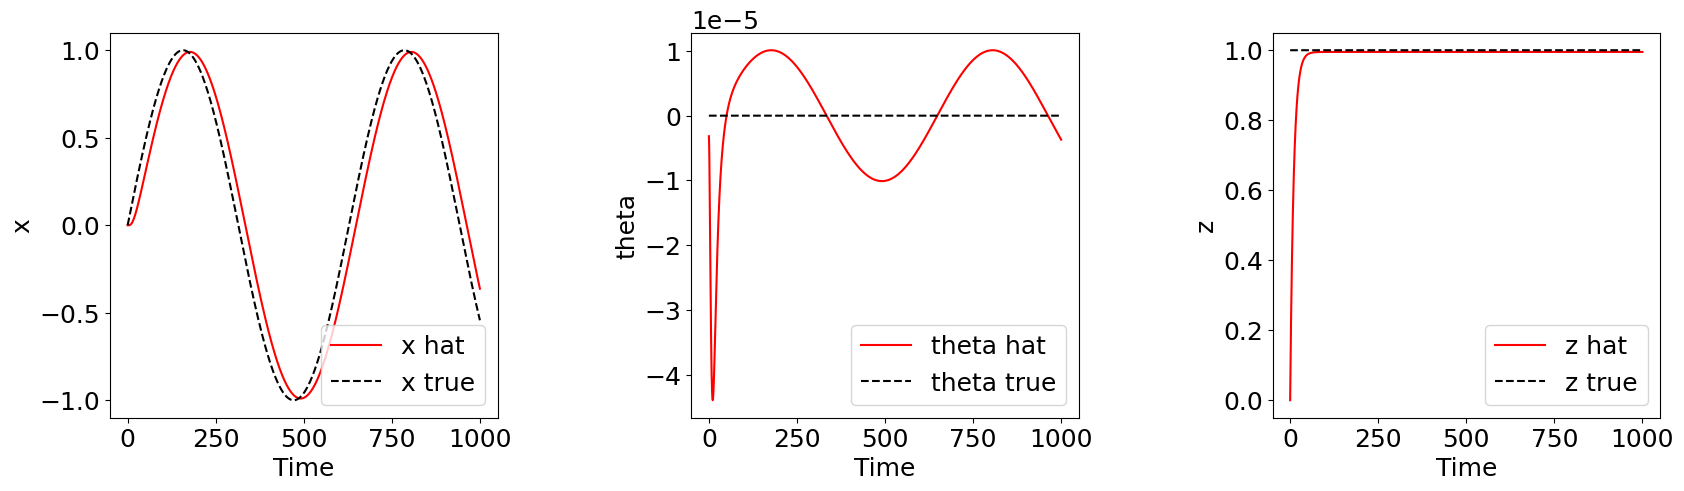

In [63]:
fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(wspace=0.5)


ax1 = fig.add_subplot(131)
plot_tme(t, x_des, None, x, label_var='x', ax=ax1)

ax2 = fig.add_subplot(132)
plot_tme(t, theta_des, None, theta, label_var='theta', ax=ax2)

ax3 = fig.add_subplot(133)
plot_tme(t, z_des, None, z, label_var='z', ax=ax3)

# Measurements

In [64]:
def h(x, v):
    theta, thetadot, x, xdot, z, zdot = x
    
    y = np.array([theta, thetadot, x, z])
    noise = np.array( [np.random.normal(0, vi) for vi in v] )
    
    return (y + noise).tolist()

In [65]:
Y = np.vstack( [h(X[:,i], v) for i in range(X.shape[1]) ] ).T

<Axes: xlabel='Time', ylabel='z'>

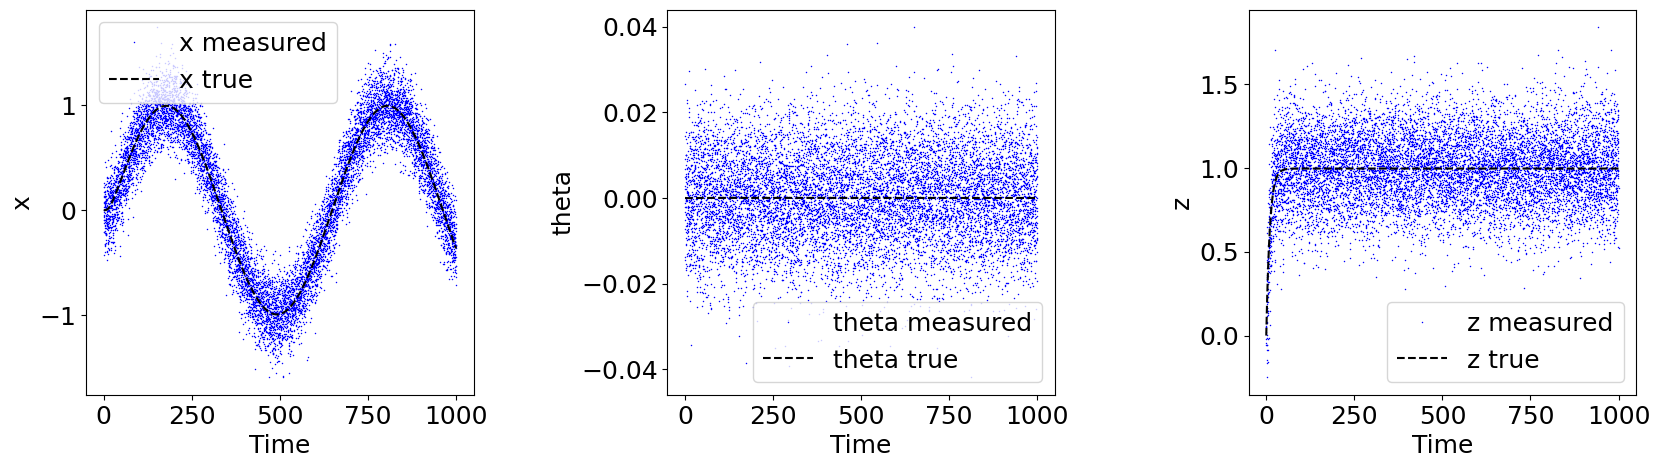

In [66]:
fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(wspace=0.5)


ax1 = fig.add_subplot(131)
plot_tme(t, x, Y[2,:], None, label_var='x', ax=ax1)

ax2 = fig.add_subplot(132)
plot_tme(t, theta, Y[0,:], None, label_var='theta', ax=ax2)

ax3 = fig.add_subplot(133)
plot_tme(t, z, Y[3,:], None, label_var='z', ax=ax3)

# Discrete Linearized

In [67]:
def control_linear(X, t):
    theta, thetadot, x, xdot, z, zdot = X
    
    # desired trajectory
    theta_des, x_des, z_des = desired_trajectory(t)
    
    # error
    x_err = x_des - x
    z_err = z_des - z
    
    # control
    tau = -(tau_k_x*x_err - tau_k_xdot*xdot)  + (tau_k_theta*(-theta) - tau_k_thetadot*thetadot)
    F = (F_k_z*z_err - F_k_zdot*zdot) - F0
    
    return F, tau

In [68]:
dt = np.mean(np.diff(t))

A = np.array([[1,        dt, 0, 0,  0, 0],
              [0,        1,  0, 0,  0, 0],
              [0,        0,  1, dt, 0, 0],
              [-F0/m*dt, 0,  0, 1,  0, 0],
              [0,        0,  0, 0,  1, dt],
              [0,        0,  0, 0,  0, 1]])

B = np.array([[0,      0],
              [0,      1/I*dt],
              [0,      0],
              [0,      0],
              [0,      0],
              [1/m*dt, 0]])

C = np.array([[1, 0, 0, 0, 0, 0],
              [0, 1, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0],
              [0, 0, 0, 0, 1, 0]])

D = np.zeros([4, 2])

# Organize some inputs for the KF

In [69]:
# get the control inputs -- these should be known
u = control_linear(X, t)
u = np.vstack(u)

# R is determined by the variance, thus the square of the standard deviation
R = np.diag(v)**2

# Q defines how trustworthy the model is. More trusted models result in smoother estimates. 
# But they can be led astray, and are slower to converge 
Q = 1e-11*np.eye(6)

# initial state estimate
x0 = [(np.random.random()-0.5)*20 for i in range(6)]
x0 = np.atleast_2d(x0).T

# initial covariance estimate
P0 = 10*np.eye(6)

# Run the KF

In [70]:
#from discrete_linear_kalman import __kalman_forward_filter__

In [71]:
url = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/discrete_linear_kalman.py'
r = requests.get(url)

# Store the file to the colab working directory
with open('discrete_linear_kalman.py', 'w') as f:
    f.write(r.text)
f.close()

from discrete_linear_kalman import __kalman_forward_filter__

In [72]:
print(np.shape(x0))
print(np.shape(P0))
print(np.shape(Y))
print(np.shape(u))
print(np.shape(A))
print(np.shape(B))
print(np.shape(C))
print(np.shape(R))
print(np.shape(Q))
xhat_fp, xhat_fm, P_fp, P_fm = __kalman_forward_filter__(x0, P0, Y, u, A, B, C, R, Q)

(6, 1)
(6, 6)
(4, 10000)
(2, 10000)
(6, 6)
(6, 2)
(4, 6)
(4, 4)
(6, 6)


In [73]:
theta_hat = xhat_fp[0, :]
x_hat = xhat_fp[2, :]
z_hat = xhat_fp[4, :]

<Axes: xlabel='Time', ylabel='z'>

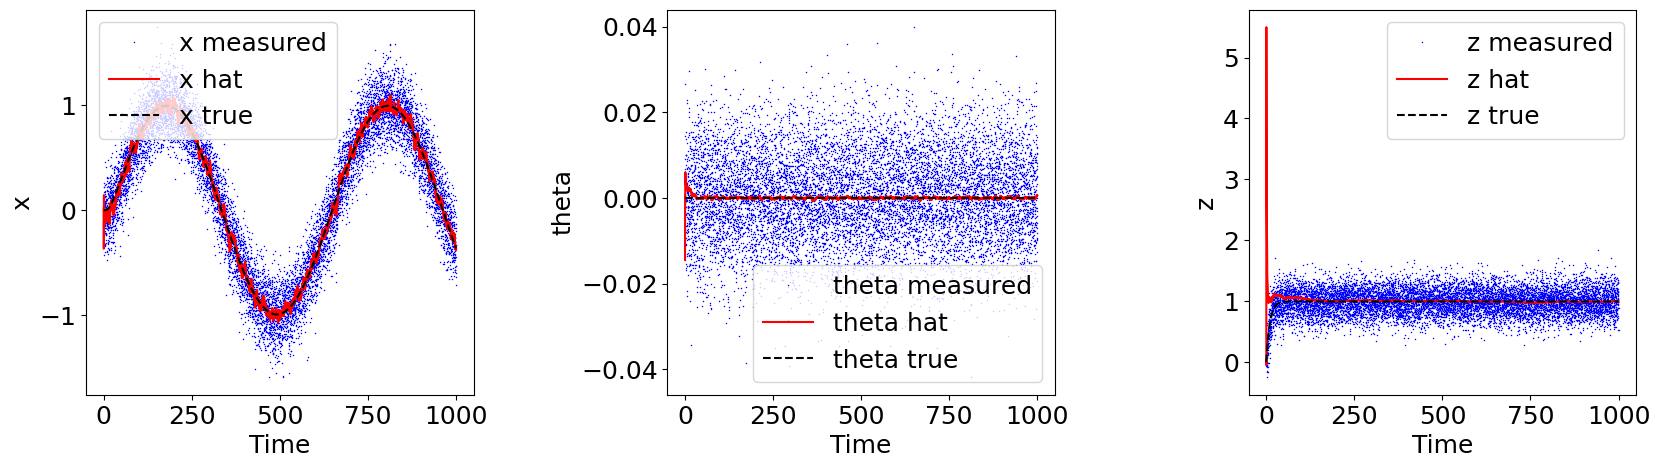

In [74]:
fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(wspace=0.5)


ax1 = fig.add_subplot(131)
plot_tme(t, x, Y[2,:], x_hat, label_var='x', ax=ax1)

ax2 = fig.add_subplot(132)
plot_tme(t, theta, Y[0,:], theta_hat, label_var='theta', ax=ax2)

ax3 = fig.add_subplot(133)
plot_tme(t, z, Y[3,:], z_hat, label_var='z', ax=ax3)

In [75]:
theta_dot_hat = xhat_fp[1, :]
x_dot_hat = xhat_fp[3, :]
z_dot_hat = xhat_fp[5, :]

theta_dot = X[1, :]
x_dot = X[3, :]
z_dot = X[5, :]

(-0.05, 0.05)

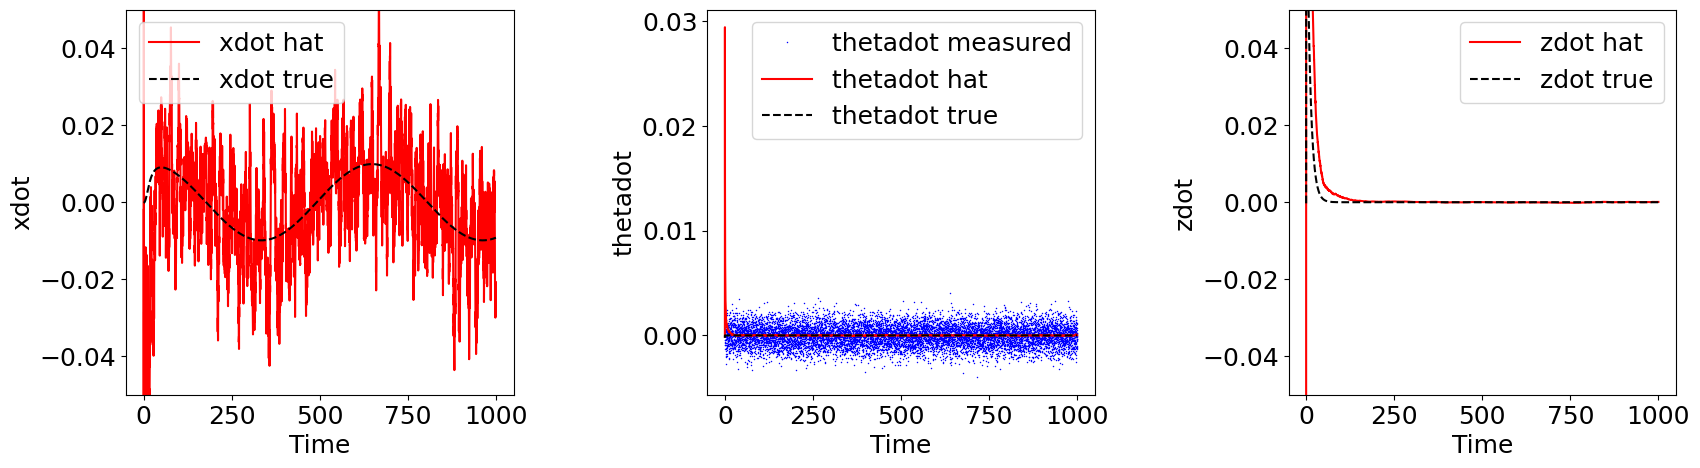

In [76]:
fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(wspace=0.5)


ax1 = fig.add_subplot(131)
plot_tme(t, x_dot, None, x_dot_hat, label_var='xdot', ax=ax1)
ax1.set_ylim(-.05, 0.05)

ax2 = fig.add_subplot(132)
plot_tme(t, theta_dot, Y[1,:], theta_dot_hat, label_var='thetadot', ax=ax2)

ax3 = fig.add_subplot(133)
plot_tme(t, z_dot, None, z_dot_hat, label_var='zdot', ax=ax3)
ax3.set_ylim(-.05, 0.05)

# Analyze the error

Focus on state x

In [77]:
# Covariance for state x

Px = np.dstack(P_fp)[2,2,:]

Recall that P is the covariance, so its diagonals are the variance. Variance = (Standard Deviation)^2.


In theory, the errors in the estimates should be well approximated by a Normal distribution with zero mean and standard deviation determined by the diagonal element of P. Lets see.

Text(0, 0.5, 'frequency')

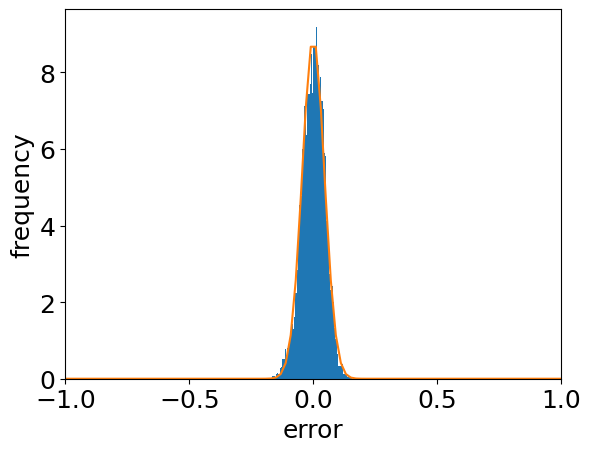

In [78]:
import scipy.stats

xr = np.linspace(-1, 1, 100)
N = scipy.stats.norm(0, np.mean(Px)**0.5 )
pdf = N.pdf(xr)

plt.hist(x_hat-x, bins=100, density=True)
plt.plot(xr, pdf)

plt.xlim(-1,1)

plt.xlabel('error')
plt.ylabel('frequency')

Furthermore, 97.7% of the errors should lie under the 3*$\sigma$ bounds. Let's see. 

Text(0, 0.5, 'error')

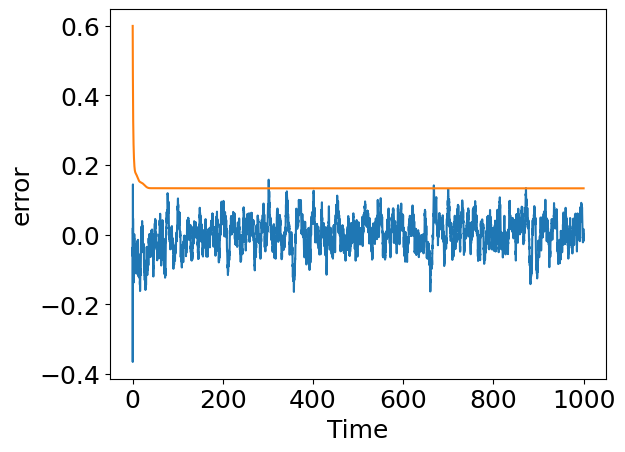

In [79]:
sigma = Px**0.5

plt.plot(t, x_hat-x)
plt.plot(t, 3*sigma)

plt.xlabel('Time')
plt.ylabel('error')

# Exercise

1. Modify so that acceleration can be used as an additional input
2. Modify so that position based measurements only arrive at 1/10th the frequency compared to acceleration

# Cramer Rao Bound

Should match P. 

In [80]:
inv = np.linalg.inv

In [81]:
Jk_diags = []

Jk = inv(P0)
for i in range(len(t)):
    Jk = inv(Q) - inv(Q)@A@inv(Jk + A.T@inv(Q)@A)@A.T@inv(Q) + C.T@inv(R)@C
    
    Jk_diags.append(np.diag( inv(Jk)) )

In [82]:
Jk_diags = np.vstack(Jk_diags).T

Text(0, 0.5, 'error')

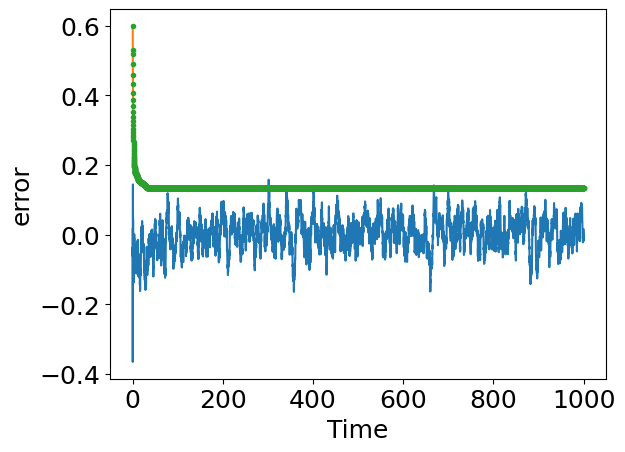

In [83]:
sigma = Px**0.5
crb = Jk_diags[2,:]**0.5

plt.plot(t, x_hat-x)
plt.plot(t, 3*sigma)
plt.plot(t, 3*crb, '.')

plt.xlabel('Time')
plt.ylabel('error')